In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.backend import clear_session
clear_session()

import keras
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten,Dropout, GlobalAveragePooling2D
from keras.models import Model,Sequential
from keras.utils import model_to_dot, plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score,precision_score,recall_score,f1_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

2024-06-06 20:39:09.365783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 20:39:09.365834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 20:39:09.366924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
with open('dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)

In [3]:
x_data, y_data = dataset

# print(len(x_data))
# print(len(x_data[0]))
# print(len(x_data[0][0]))
# print(len(x_data[0][0][0]))

# print(x_data[1].shape)


for x in range(len(x_data)-1):
    #print(x)
    if not x_data[x].shape == (128, 128, 3):
        del x_data[x]
        y_data = np.delete(y_data, x)
        #print(x)

x_array = np.array(x_data)
y_array = np.array(y_data)

print(x_array.shape)
print(y_array.shape)

(9999, 128, 128, 3)
(9999,)


In [4]:

def create_train_test_splits(x_array, y_array, train_slices, test_slices):
    """
    Create training and testing datasets based on provided slices.

    Parameters:
    - x_array: numpy array of features.
    - y_array: numpy array of labels.
    - train_slices: list of tuples, each specifying a slice for training data.
    - test_slices: list of tuples, each specifying a slice for testing data.

    Returns:
    - x_train, y_train: numpy arrays for training features and labels.
    - x_test, y_test: numpy arrays for testing features and labels.
    """
    x_train = np.concatenate([x_array[start:end] for start, end in train_slices], axis=0)
    y_train = np.concatenate([y_array[start:end] for start, end in train_slices], axis=0)
    x_test = np.concatenate([x_array[start:end] for start, end in test_slices], axis=0)
    y_test = np.concatenate([y_array[start:end] for start, end in test_slices], axis=0)
    
    return x_train, y_train, x_test, y_test

# Define slices for training and testing
train_slices = [(0, 799), (1000, 1799), (2000, 2799), (3000, 3799), 
                (4000, 4799), (5000, 5799), (6000, 6799), (7000, 7799), 
                (8000, 8799), (9000, 9799)]

test_slices = [(800, 999), (1800, 1999), (2800, 2999), (3800, 3999), 
               (4800, 4999), (5800, 5999), (6800, 6999), (7800, 7999), 
               (8800, 8999), (9800, 9999)]

x_train, y_train, x_test, y_test = create_train_test_splits(x_array, y_array, train_slices, test_slices)

x_array = []
y_array = []


In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7990, 128, 128, 3)
(7990,)
(1990, 128, 128, 3)
(1990,)


In [6]:
# Normalize the image data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [7]:
#Constant
bs = 64
lr = 0.0001
size = (128, 128)

shape = (128,128, 3) 
epochs = 10
class_number = 10


In [8]:

inputs = Input(shape=(128,128,3))


x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(units=128, activation="relu")(x)
x = Dropout(0.5)(x) 
outputs = Dense(class_number, activation='softmax')(x)

In [9]:
model_m1 = Model(inputs=inputs, outputs=outputs)

model_m1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,486,986 (9.49 MB)

 Trainable params: 2,486,986 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
for layer in model_m1.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Conv2D name=conv2d, built=True> True
<MaxPooling2D name=max_pooling2d, built=True> True
<Conv2D name=conv2d_1, built=True> True
<MaxPooling2D name=max_pooling2d_1, built=True> True
<Conv2D name=conv2d_2, built=True> True
<MaxPooling2D name=max_pooling2d_2, built=True> True
<Conv2D name=conv2d_3, built=True> True
<MaxPooling2D name=max_pooling2d_3, built=True> True
<Dropout name=dropout, built=True> True
<Flatten name=flatten, built=True> True
<Dense name=dense, built=True> True
<Dropout name=dropout_1, built=True> True
<Dense name=dense_1, built=True> True


In [11]:
model_m1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [12]:
start_time = time.time()
print("batch_size :",bs)
# Train the model
history = model_m1.fit(
    x_train,
    y_train,
    batch_size= bs,
    epochs=20,
    verbose=1,
    #callbacks=callback_list,
    validation_data=(x_test, y_test)
)
cnn_train_time = time.time() - start_time

batch_size : 64
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 390ms/step - accuracy: 0.1458 - loss: 2.2597 - val_accuracy: 0.2583 - val_loss: 2.0133
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 387ms/step - accuracy: 0.2372 - loss: 2.0610 - val_accuracy: 0.3487 - val_loss: 1.9164
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 385ms/step - accuracy: 0.3153 - loss: 1.8924 - val_accuracy: 0.3804 - val_loss: 1.7488
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 383ms/step - accuracy: 0.3766 - loss: 1.7611 - val_accuracy: 0.4256 - val_loss: 1.6568
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 383ms/step - accuracy: 0.4228 - loss: 1.6803 - val_accuracy: 0.4774 - val_loss: 1.5584
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 384ms/step - accuracy: 0.4331 - loss: 1.5808 - val_accuracy: 0.4638 - val_loss: 1.5619
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 385ms/step - accuracy: 0.4612 - loss: 1.5132 - val_accuracy: 0.4889 - val_loss: 1.4955
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 383ms/step - accuracy: 

In [13]:
# model_m1.save('model/my_model_A.keras')
print(cnn_train_time)

966.4397554397583


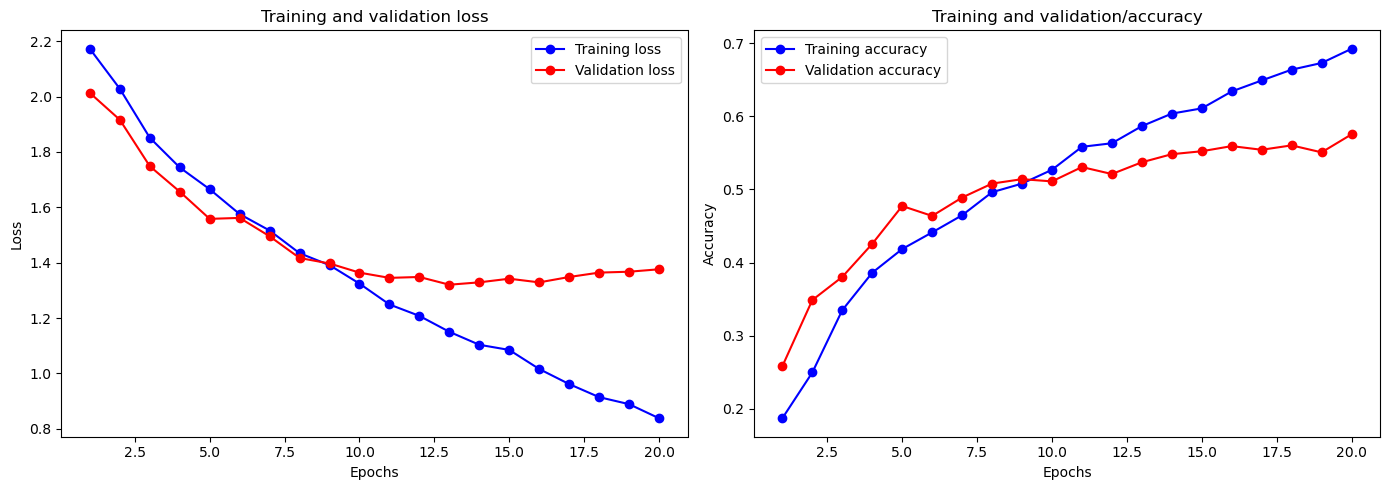

In [14]:
def plot_loss_and_accuracy(history):
    """
    Plots the loss and accuracy from the training history.
    
    Parameters:
    history: History object returned by the `fit` method of a Keras model.
    """
    # Get the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    
    # Plot loss
    plt.figure(figsize=(14, 5))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and validation/accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_loss_and_accuracy(history)

In [15]:
start_time = time.time()
y_pred = np.argmax(model_m1.predict(x_test), axis=1)
cnn_train_time = time.time() - start_time

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


In [16]:

# Calculate classification metrics
classification_accuracy = accuracy_score(y_test, y_pred)
classification_precision = precision_score(y_test, y_pred, average='weighted')
classification_recall = recall_score(y_test, y_pred, average='weighted')
classification_f1 = f1_score(y_test, y_pred, average='weighted')

In [17]:
y_pred_test = model_m1.predict(x_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


Classification Metrics:
Accuracy: 0.5753768844221105
Precision: 0.5668550990880549
Recall: 0.5753768844221105
F1-Score: 0.5685782169469243
Confusion Matrix:
[[ 93  17   8   3  27  35   7   4   2   3]
 [ 20  82  14  16   9  31   8  10   6   3]
 [  3  22 148   3   5   9   0   1   3   5]
 [  0   6   2 151   7   2   5  12   3  11]
 [  9  15   9  11  76  19  12  15  11  22]
 [ 32  36  22  10  22  58   6   4   2   7]
 [  0   1   1   9  11   1 145  19   4   8]
 [  3   4   1   3   5   2   5 150  13  13]
 [  0   1   1   3   3   0   1  21 148  21]
 [  5  11   3  11  17   4   7  28  19  94]]


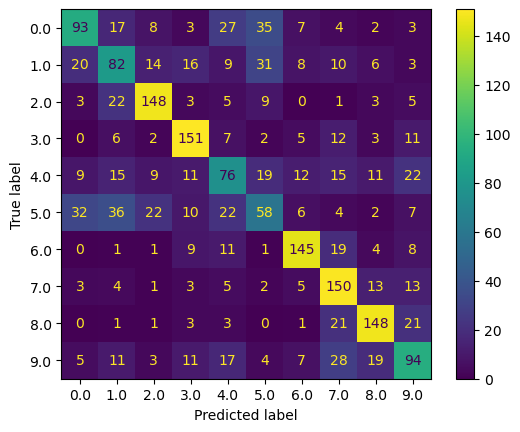

In [18]:
print("Classification Metrics:")
print(f"Accuracy: {classification_accuracy}")
print(f"Precision: {classification_precision}")
print(f"Recall: {classification_recall}")
print(f"F1-Score: {classification_f1}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
confusion_matrix_display.plot()
plt.show()

In [19]:
feature_extractor = tf.keras.Model(inputs=model_m1.input, outputs=model_m1.layers[-4].output)

In [20]:
feature_extractor.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,416 (1.48 MB)

 Trainable params: 388,416 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
start_time = time.time()
# Extract features from the training and test sets
x_train_features = feature_extractor.predict(x_train)
x_test_features = feature_extractor.predict(x_test)

feature_extraction_time = time.time() - start_time

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


In [22]:
#Flatten the features for the SVM
x_train_features_flat = x_train_features.reshape(x_train_features.shape[0], -1)
x_test_features_flat = x_test_features.reshape(x_test_features.shape[0], -1)
print(f"x_train_features_flat shape: {x_train_features_flat.shape}")
print(f"x_test_features_flat shape: {x_test_features_flat.shape}")

# Ensure labels are in the correct format
y_train_labels = y_train
y_test_labels = y_test

print(f"x_train_features_flat shape: {y_train_labels.shape}")
print(f"x_test_features_flat shape: {y_test_labels.shape}")

x_train_features_flat shape: (7990, 16384)
x_test_features_flat shape: (1990, 16384)
x_train_features_flat shape: (7990,)
x_test_features_flat shape: (1990,)


In [23]:
# Train the SVM classifier
svm_model = make_pipeline(StandardScaler(), SVC(probability=True))

In [ ]:
from time import sleep
from tqdm import tqdm

In [ ]:
# One-vs-One (OvO) SVM
start_time = time.time()
ovo_svm = OneVsOneClassifier(svm_model)
ovo_svm.fit(x_train_features_flat, y_train_labels)
ovo_train_time = time.time() - start_time

for element in tqdm(start_time):
    sleep(0.1)

# One-vs-All (OvA) SVM
start_time = time.time()
ova_svm = OneVsRestClassifier(svm_model)
ova_svm.fit(x_train_features_flat, y_train_labels)
ova_train_time = time.time() - start_time

for element in tqdm(start_time):
    sleep(0.1)

In [ ]:
#Evaluate One-vs-One (OvO) SVM
start_time = time.time()
ovo_predictions = ovo_svm.predict(x_test_features_flat)
ovo_test_time = time.time() - start_time
ovo_accuracy = accuracy_score(y_test_labels, ovo_predictions)
print(f"OvO SVM accuracy: {ovo_accuracy}")

# Evaluate One-vs-All (OvA) SVM
start_time = time.time()
ova_predictions = ova_svm.predict(x_test_features_flat)
ova_test_time = time.time() - start_time
ova_accuracy = accuracy_score(y_test_labels, ova_predictions)
print(f"OvA SVM accuracy: {ova_accuracy}")


In [ ]:
# Function to print classification metrics
def print_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Classification Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    confusion_matrix_display.plot(cmap=plt.cm.Blues)
    plt.show()

# Evaluate One-vs-One (OvO) SVM
ovo_predictions = ovo_svm.predict(x_test_features_flat)
print("OvO SVM Results:")
print_classification_metrics(y_test_labels, ovo_predictions)

# Evaluate One-vs-All (OvA) SVM
ova_predictions = ova_svm.predict(x_test_features_flat)
print("OvA SVM Results:")
print_classification_metrics(y_test_labels, ova_predictions)